In [5]:
import pyodbc
import pandas as pd

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# query excludes observations that don't have 'meeting type', 'meeting type' is ambiguous or
# the meeting took place prior to when Scottsdale was incorporated(1951), probably human data entry error
Case_Query = '''
select *
from [dbo].[pds_CaseMeetings]
where [MeetingType] <> '' and [MeetingType] <> 'Other' and year([MeetingDate]) > '1951' 
  '''
# save the sql query to a pandas dataframe
Case_Data = pd.read_sql(Case_Query, connection)
connection.close()

Case_Data['MeetingDate'] = pd.to_datetime(Case_Data['MeetingDate']) #converte MeetingDate to datetime format
Case_Data['MeetingDate'] = Case_Data['MeetingDate'].dt.year #converte MeetingDate to year
# Case_Data.head(10)
Case_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15401 entries, 0 to 15400
Data columns (total 7 columns):
meeting_id     15401 non-null object
case_id        15401 non-null object
CaseNumber     15401 non-null object
MeetingType    15401 non-null object
MeetingDate    15401 non-null int64
Result         15401 non-null object
Vote           15401 non-null object
dtypes: int64(1), object(6)
memory usage: 842.3+ KB


Text(0.5, 1.0, 'Count of Case Meetings Over Time')

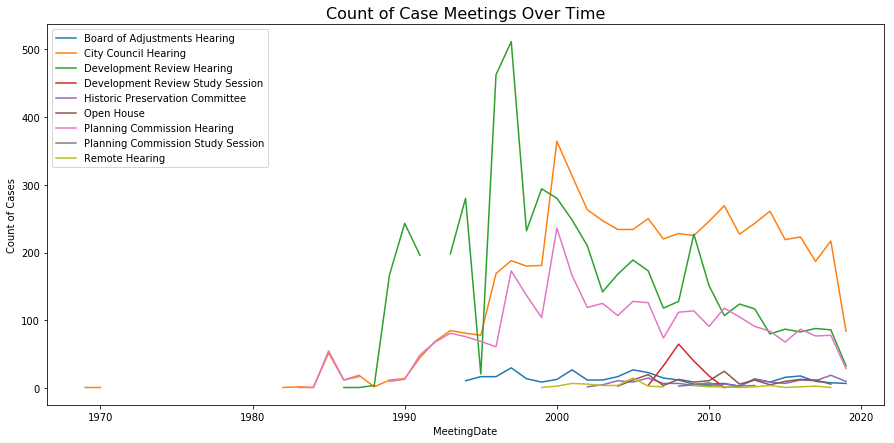

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
Case_Data.groupby(['MeetingDate','MeetingType']).count()['meeting_id'].unstack().plot(ax=ax)
plt.legend(loc='upper left')
plt.ylabel("Count of Cases")
plt.title("Count of Case Meetings Over Time",fontsize=16)

#since around 2000, why have City Council Hearings begun to be more prevelent than Development Review Hearings?

(1990, 2020)

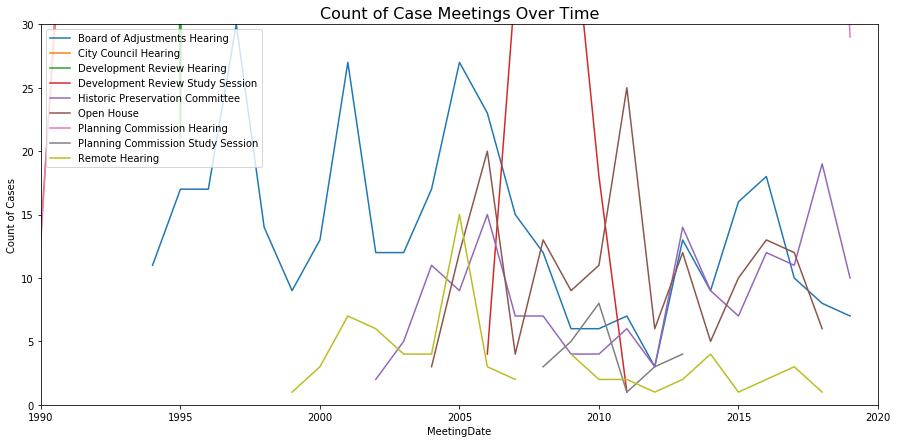

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
Case_Data.groupby(['MeetingDate','MeetingType']).count()['meeting_id'].unstack().plot(ax=ax)
plt.legend(loc='upper left')
plt.ylabel("Count of Cases")
plt.title("Count of Case Meetings Over Time",fontsize=16)
ax.set_ylim(0, 30)
ax.set_xlim(1990, 2020)

# zooming in on hearings with a smaller count per year
# since 2010 a much higher number of hearings for different purposes, such as 'Open House'

In [8]:
Case_Data.groupby(['Result'])['Result'].count().sort_values(ascending=False)
# how many unique types of Case Results are there?
# what is the count of Cases that fall into each category?
# why are there so many cases with no result value?

Result
APPROVED                          10930
CONTINUED                          1600
                                    740
WITHDRAWN                           500
DENIED                              281
RECOMMENDATION                      240
RECOMMENDATION OF APPROVAL          239
                                    236
RECOMMENDED                         190
AMENDED                             127
INFORMATIONAL ONLY                   72
PENDING                              64
ON HOLD                              49
NON-ACTION                           35
APPROVED WITH STIPS                  30
INITIATED                            24
CONSENT TO SA                        16
UPHELD                               10
CERTIFICATE OF APPROPRIATENESS        8
RECOMMENDATION OF CONTINUANCE         3
RECOMMENDATION OF DENIAL              2
CONCEPTIONALLY APPROVED               1
CERTIFICATE OF APPRO                  1
NO JURISDICTION                       1
OVERTURNED                       

In [9]:
# select only for cases either 'Approved' or 'Denied' based on hearing
Case_Data_App_Den = Case_Data.loc[(Case_Data['Result'] == 'DENIED') | (Case_Data['Result'] == 'APPROVED')]
Case_Data_App_Den.groupby(['Result'])['Result'].count()

# Count of approved cases vs. denied cases

Result
APPROVED    10930
DENIED        281
Name: Result, dtype: int64

(1980, 2020)

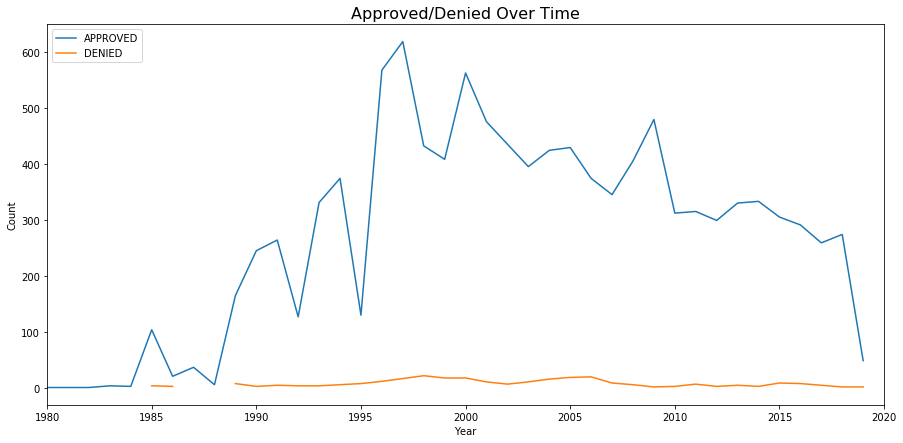

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
Case_Data_App_Den.groupby(['MeetingDate','Result'])['Result'].count().unstack().plot(ax=ax)

plt.legend(loc='upper left')
plt.ylabel("Count")
plt.xlabel("Year")
plt.title("Approved/Denied Over Time",fontsize=16)
ax.set_xlim(1980, 2020)

# Cases approved vs. denied over time

In [13]:
#clean data and form attributes to measure 'against' votes
Case_Data['Vote'] = Case_Data['Vote'].str.replace(' ','') #remove leading and trailing white spaces
Case_Data['For_Vote'] = Case_Data['Vote'].str[0].apply(pd.to_numeric, args=('coerce',)) #extract 'for' votes, convert to numeric
Case_Data['Against_Vote'] = Case_Data['Vote'].str[2].apply(pd.to_numeric, args=('coerce',)) #extract 'against' votes, convert to numeric
Case_Data['Opposition_Score'] = Case_Data['Against_Vote']/Case_Data['For_Vote'] # divide 'against' votes by 'for' votes

Sorted = Case_Data.sort_values(by=['Opposition_Score'],ascending=False)
Sorted.head(10)

,meeting_id,case_id,CaseNumber,MeetingType,MeetingDate,Result,Vote,For_Vote,Against_Vote,Opposition_Score
11544,12573,24545,102-LL-2002,City Council Hearing,2003,DENIED,0-6,0.0,6.0,inf
3155,10718,22922,2-UP-2002,Planning Commission Hearing,2002,DENIED,1-4,1.0,4.0,4.000000
10787,24882,28012,28-UP-2004,City Council Hearing,2006,DENIED,2-5,2.0,5.0,2.500000
10068,8660,6378,29-ZN-1993,Planning Commission Hearing,1993,DENIED,2-4,2.0,4.0,2.000000
685,48408,45637,60-DR-2015,Development Review Hearing,2016,DENIED,2-4,2.0,4.0,2.000000
11737,22175,29214,4-BA-2005,Board of Adjustments Hearing,2005,DENIED,3-4,3.0,4.0,1.333333
9981,8565,16100,71-ZN-1994,City Council Hearing,1995,DENIED,3-4,3.0,4.0,1.333333
919,46707,43757,6-TA-2014,City Council Hearing,2015,DENIED,3-4,3.0,4.0,1.333333
14262,37841,39548,1-II-2010#2,City Council Hearing,2011,DENIED,3-4,3.0,4.0,1.333333
2667,46296,44530,1-ZN-2015,City Council Hearing,2015,DENIED,3-4,3.0,4.0,1.333333


(1990, 2020)

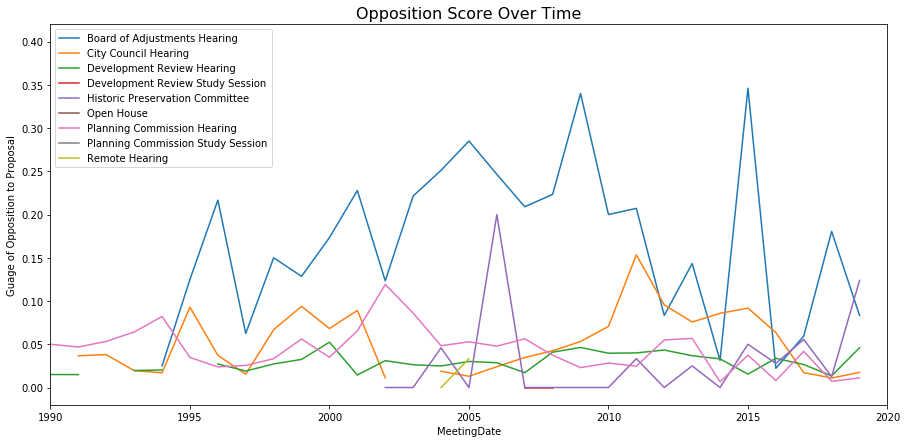

In [15]:
#plot opposition score over years
fig, ax = plt.subplots(figsize=(15,7))
Case_Data.groupby(['MeetingDate','MeetingType']).mean()['Opposition_Score'].unstack().plot(ax=ax)
plt.legend(loc='upper left')
plt.ylabel("Guage of Opposition to Proposal")
plt.title("Opposition Score Over Time",fontsize=16)
ax.set_xlim(1990, 2020)

# although Board of Adjustment Hearings make up a small portion of total hearings each year,
# why are they consistently the most contentious of all hearings over time